In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *



## here we're running with the likelihood only 

In [2]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_75986/1184199116.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [3]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

In [5]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_75986/1949801412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt

In [6]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [7]:
# Load references (signatures only, no healthy)
refs = torch.load('reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_75986/2429096507.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('reference_trajectories.pt'

In [8]:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-18.4207, -18.4207, -17.3858, -16.3508, -16.3508])
Base value centered (first 5): tensor([-0.5458, -0.5458,  0.4891,  1.5240,  1.5240])
Base value centered mean: 3.23352810482902e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0101,  0.0173,  0.0224, -0.0156])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-18.4207, -18.4207, -18.4207, -18.4207, -18.4207])
Base value centered

In [9]:
print(model.K_total)
print(model.K)
print(model.lrtpen)

21
20
0


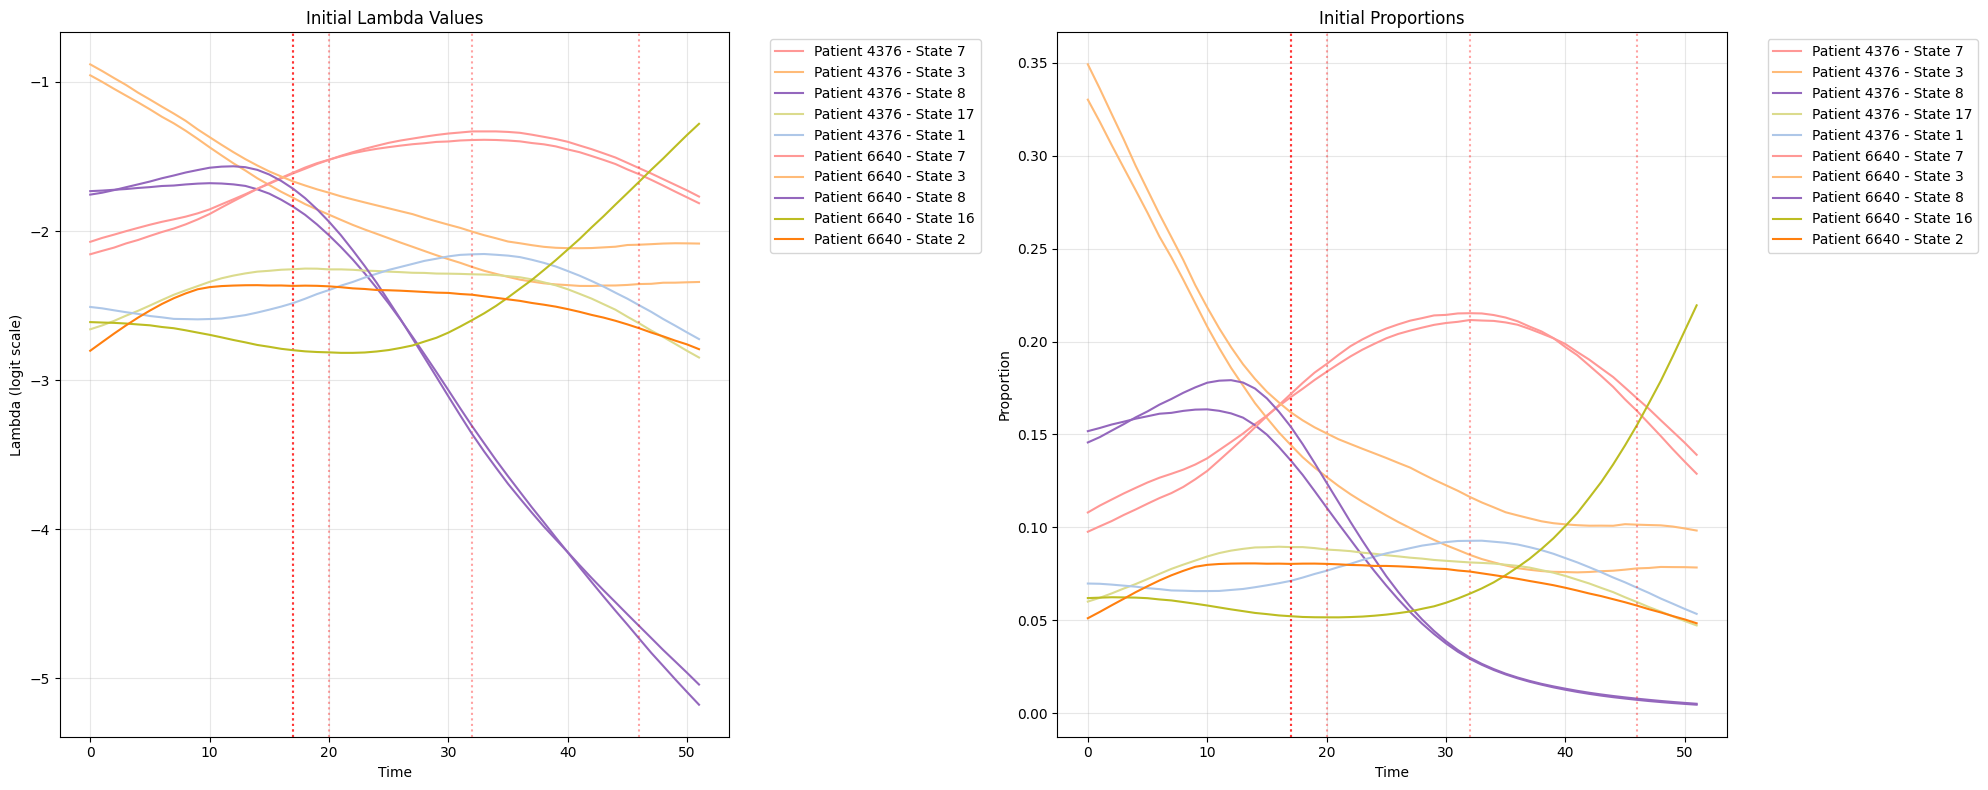


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.139
Range of shifts: [-0.131, 0.461]

Top states and average proportions:
State 7: 0.172
State 3: 0.139
State 8: 0.080
State 17: 0.076
State 1: 0.076

Patient 6640:
Mean shift: 0.040
Std of shifts: 0.079
Range of shifts: [-0.164, 0.232]

Top states and average proportions:
State 7: 0.169
State 3: 0.161
State 8: 0.085
State 16: 0.082
State 2: 0.071


In [10]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times for this patient
    diagnoses = model.Y[patient]  # Shape: [D, T]
    diagnosis_times = []
    for d in range(model.D):
        diag_time = torch.where(diagnoses[d])[0]
        if len(diag_time) > 0:
            diagnosis_times.append(diag_time[0].item())
            
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')
    
    # Add vertical lines for diagnoses
    for t in diagnosis_times:
        ax1.axvline(x=t, color='red', alpha=0.2, linestyle=':')
        ax2.axvline(x=t, color='red', alpha=0.2, linestyle=':')

# Customize plots
ax1.set_title('Initial Lambda Values')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Initial Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects and top states
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [11]:
print(f"LRT penalty (R): {model.lrtpen}")
print(f"Lambda amplitude: {model.lambda_amplitude}")
print(f"GP Weight: {model.gpweight}")

LRT penalty (R): 0
Lambda amplitude: 1
GP Weight: 0.0001


In [13]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()



In [14]:
import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_100k, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)
        

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 65.7955

Monitoring signature responses:

Disease 161 (signature 7, LR=32.38):
  Theta for diagnosed: 0.151 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.81):
  Theta for diagnosed: 0.150 ± 0.039
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 260 (signature 8, LR=30.45):
  Theta for diagnosed: 0.089 ± 0.074
  Theta for others: 0.087
  Proportion difference: 0.002

Disease 347 (signature 3, LR=29.51):
  Theta for diagnosed: 0.149 ± 0.070
  Theta for others: 0.150
  Proportion difference: -0.001

Disease 50 (signature 15, LR=28.94):
  Theta for diagnosed: 0.016 ± 0.006
  Theta for others: 0.014
  Proportion difference: 0.002

Epoch 1
Loss: 707.4540

Monitoring signature responses:

Disease 161 (signature 7, LR=32.57):
  Theta for diagnosed: 0.151 ± 0.036
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.82):
  Theta for diagnosed: 0.150 ± 0.037
  Theta for others: 0

In [16]:
model.kappa

Parameter containing:
tensor([2.9875], requires_grad=True)

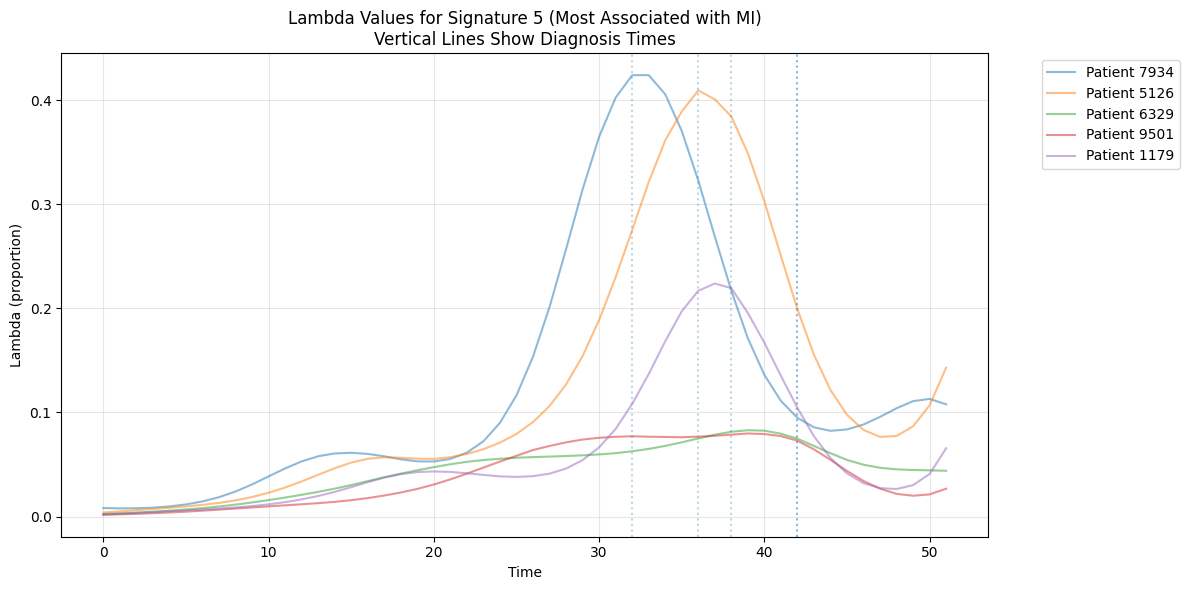

In [15]:
def plot_disease_lambda_alignment(model):
    """
    Plot lambda values aligned with disease occurrences for selected patients
    """
    # Find patients with specific diseases and their diagnosis times
    disease_idx = 112  # MI
    patients_with_disease = []
    diagnosis_times = []
    
    for patient in range(model.Y.shape[0]):
        diag_time = torch.where(model.Y[patient, disease_idx])[0]
        if len(diag_time) > 0:
            patients_with_disease.append(patient)
            diagnosis_times.append(diag_time[0].item())
    
    # Sample a few patients
    n_samples = min(5, len(patients_with_disease))
    sample_indices = np.random.choice(len(patients_with_disease), n_samples, replace=False)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    time_points = np.arange(model.T)
    
    # Find signature that most strongly associates with this disease
    psi_disease = model.psi[:, disease_idx].detach()
    sig_idx = torch.argmax(psi_disease).item()
    
    # Plot for each sampled patient
    for idx in sample_indices:
        patient = patients_with_disease[idx]
        diag_time = diagnosis_times[idx]
        
        # Plot lambda (detached)
        lambda_values = torch.softmax(model.lambda_[patient].detach(), dim=0)[sig_idx]
        ax.plot(time_points, lambda_values.numpy(),
                alpha=0.5, label=f'Patient {patient}')
        
        # Mark diagnosis time
        ax.axvline(x=diag_time, linestyle=':', alpha=0.3)
    
    ax.set_title(f'Lambda Values for Signature {sig_idx} (Most Associated with MI)\nVertical Lines Show Diagnosis Times')
    ax.set_xlabel('Time')
    ax.set_ylabel('Lambda (proportion)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_disease_lambda_alignment(model)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_75986/2612062181.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


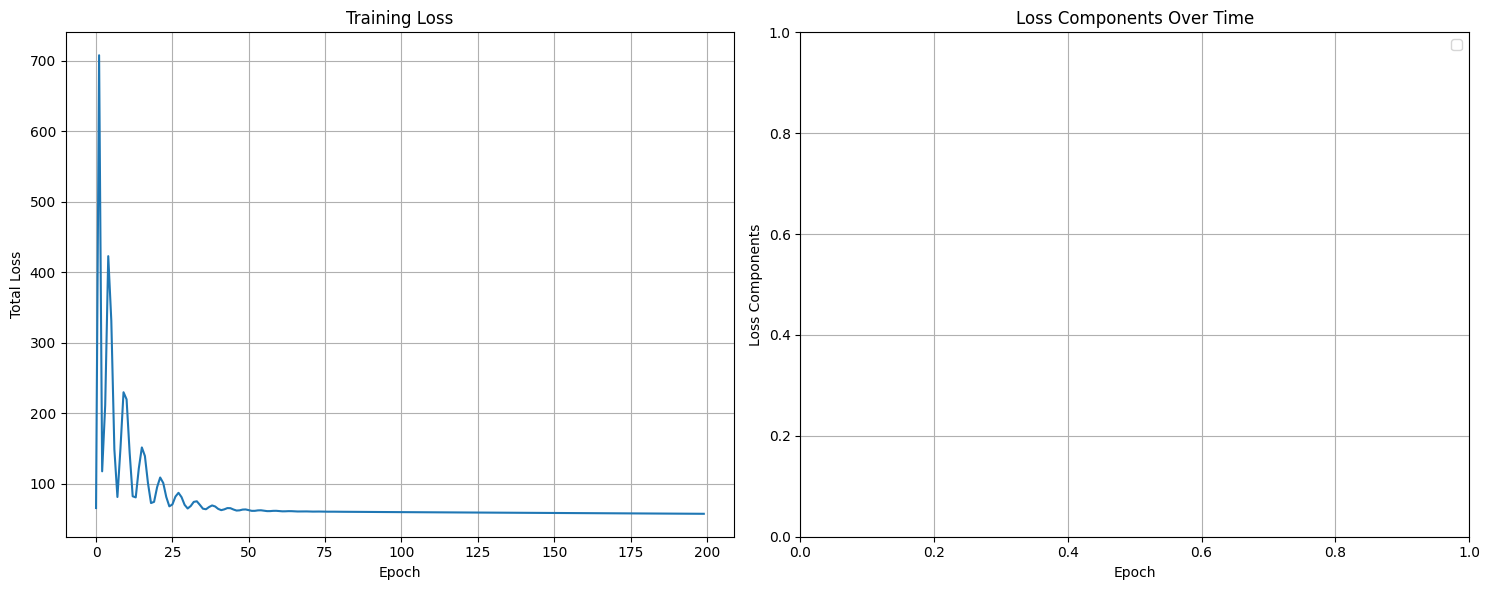

In [17]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot total loss
    ax1.plot(history)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)

    # Plot component losses
    # Extract from printed output
    epochs = range(len(history))
    #data_losses = [65.6950, 65.6198, 65.5456, 65.4711, 65.3961, 65.3208, 65.2452, 65.1694, 65.0936, 65.0177, 64.9418, 64.8659, 64.7899, 64.7138, 64.6375, 64.5610, 64.4845, 64.4078, 64.3310, 64.2542]
    #gp_losses = [5.6859, 459.7293, 32.8175, 100.4279, 259.7525, 182.3966, 42.2339, 6.2529, 75.5871, 130.6093, 105.0365, 40.0023, 4.2676, 21.8158, 58.3701, 68.2091, 43.7377, 13.1755, 4.6903, 19.4461]
    #lrt_losses = [16456.7656, 16413.8711, 16375.5742, 16337.2236, 16297.7764, 16257.2930, 16216.2754, 16175.0986, 16134.0918, 16093.5273, 16053.4570, 16013.7744, 15974.3174, 15934.9131, 15895.3779, 15855.5889, 15815.5312, 15775.2656, 15734.9033, 15694.5830]

    #ax2.plot(epochs, data_losses, label='Data Loss', color='blue')
    #ax2.plot(epochs, gp_losses, label='GP Loss', color='green')
    #ax2.plot(epochs, lrt_losses, label='LRT Loss', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Components')
    ax2.set_title('Loss Components Over Time')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history_new)

In [63]:
## do the cluster assignemtns still map?


# Get the signature with maximum psi for each disease
max_psi_indices = torch.argmax(final_psi, dim=0)  # Shape: [D]

# Compare with cluster assignments
matches = 0
total = len(model.clusters)

print("Comparing max psi signatures with cluster assignments:")
for k in range(model.K):
    # Find diseases assigned to cluster k
    cluster_diseases = np.where(model.clusters == k)[0]
    # Find diseases where k has maximum psi
    max_psi_diseases = np.where(max_psi_indices == k)[0]
    
    overlap = set(cluster_diseases) & set(max_psi_diseases)
    
    print(f"\nCluster {k}:")
    print(f"Number of diseases in cluster: {len(cluster_diseases)}")
    print(f"Number of diseases where this signature has max psi: {len(max_psi_diseases)}")
    print(f"Overlap: {len(overlap)}")
    
    matches += len(overlap)

print(f"\nOverall agreement: {matches}/{total} diseases ({matches/total*100:.1f}%)")

Comparing max psi signatures with cluster assignments:

Cluster 0:
Number of diseases in cluster: 16
Number of diseases where this signature has max psi: 16
Overlap: 16

Cluster 1:
Number of diseases in cluster: 21
Number of diseases where this signature has max psi: 21
Overlap: 21

Cluster 2:
Number of diseases in cluster: 15
Number of diseases where this signature has max psi: 15
Overlap: 15

Cluster 3:
Number of diseases in cluster: 82
Number of diseases where this signature has max psi: 82
Overlap: 82

Cluster 4:
Number of diseases in cluster: 5
Number of diseases where this signature has max psi: 5
Overlap: 5

Cluster 5:
Number of diseases in cluster: 7
Number of diseases where this signature has max psi: 7
Overlap: 7

Cluster 6:
Number of diseases in cluster: 8
Number of diseases where this signature has max psi: 8
Overlap: 8

Cluster 7:
Number of diseases in cluster: 22
Number of diseases where this signature has max psi: 22
Overlap: 22

Cluster 8:
Number of diseases in cluster:

In [64]:
model.psi[:,112]

tensor([-2.4133, -2.0282, -2.0700, -2.1973, -1.9229, -1.2272, -2.1277, -2.0557,
        -2.0092, -2.2590, -2.1735, -2.0738, -2.0585, -2.0330, -1.8766, -1.9685,
        -2.5690, -2.4836, -2.0029, -2.0967, -4.9747],
       grad_fn=<SelectBackward0>)

In [18]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-2:
Mean absolute change: 6.130e-02
Max absolute change: 7.114e+00
Std of changes: 1.551e-01


In [59]:
final_psi= model.psi.detach().clone()
diff = torch.abs(final_psi - initial_psi)

print(f"Psi changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Psi changes with lr=1e-2:
Mean absolute change: 1.511e-01
Max absolute change: 2.594e+00
Std of changes: 3.017e-01


In [61]:
final_phi= model.phi.detach().clone()
diff = torch.abs(final_phi - initial_phi)

print(f"Phi changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Phi changes with lr=1e-2:
Mean absolute change: 1.742e-02
Max absolute change: 1.920e+00
Std of changes: 6.796e-02


In [62]:
final_psi.shape

torch.Size([21, 348])

In [19]:
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


Clusters match exactly: True


In [20]:
model.clusters[17]

np.int32(19)

In [21]:
def plot_theta_differences():
    diseases = [112, 67, 127, 10, 17]
    signatures = [5, 7, 0, 17, 19]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (d, sig) in enumerate(zip(diseases, signatures)):
        ax = axes[i]
        
        # Get diagnosis times
        diagnosis_mask = model.Y[:, d, :].bool()
        diagnosed = torch.where(diagnosis_mask)[0]
        
        # Get thetas
        pi, theta, phi_prob = model.forward()
        
        # Plot distributions
        diagnosed_theta = theta[diagnosis_mask, sig].detach().numpy()
        others_theta = theta[~diagnosis_mask, sig].detach().numpy()
        
        ax.hist(diagnosed_theta, alpha=0.5, label='At diagnosis', density=True)
        ax.hist(others_theta, alpha=0.5, label='Others', density=True)
        
        ax.set_title(f'Disease {d} (sig {sig})')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

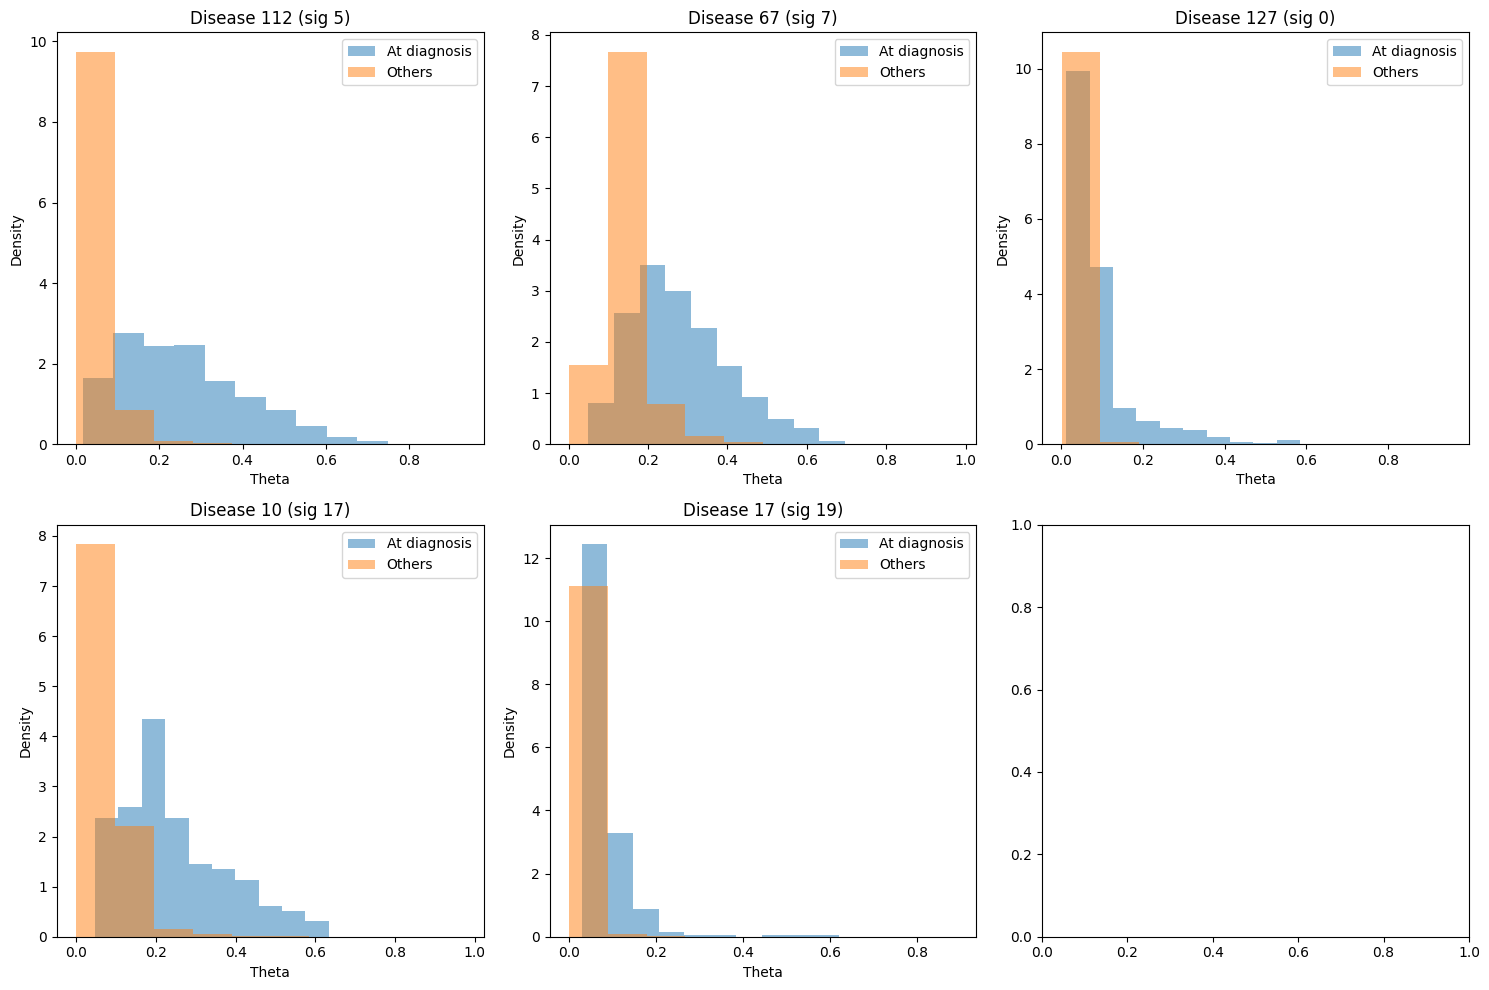

In [195]:
plot_theta_differences()

In [22]:
model.gpweight

0.0001

In [23]:
# Get μ_dt from checkpoint and predictions
mu_dt = model.prevalence_t  # Shape: (348, 52)



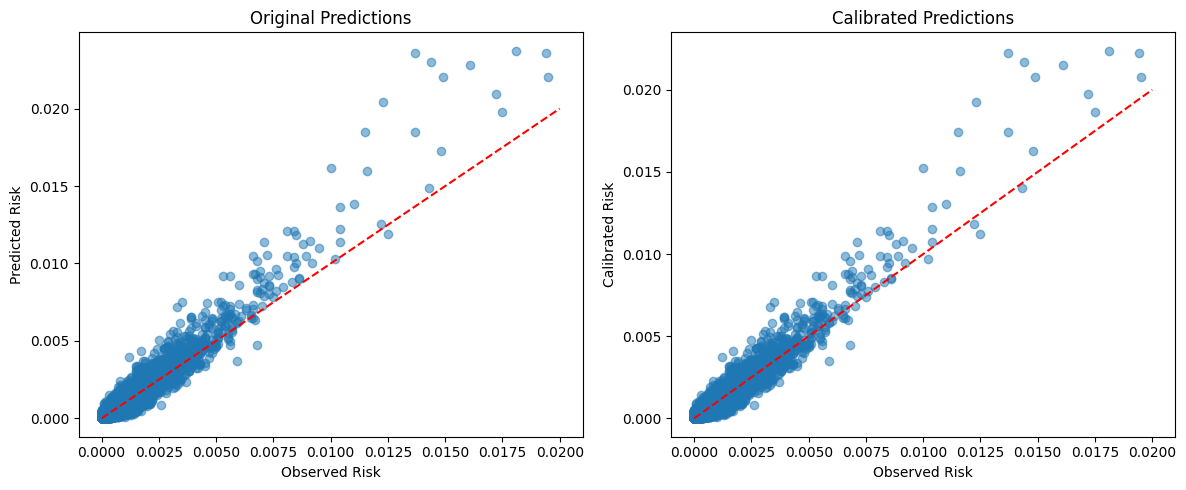

Mean observed risk: 0.000438
Mean predicted risk (original): 0.000464
Mean predicted risk (calibrated): 0.000438
Calibration scale factor: 0.943


In [24]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


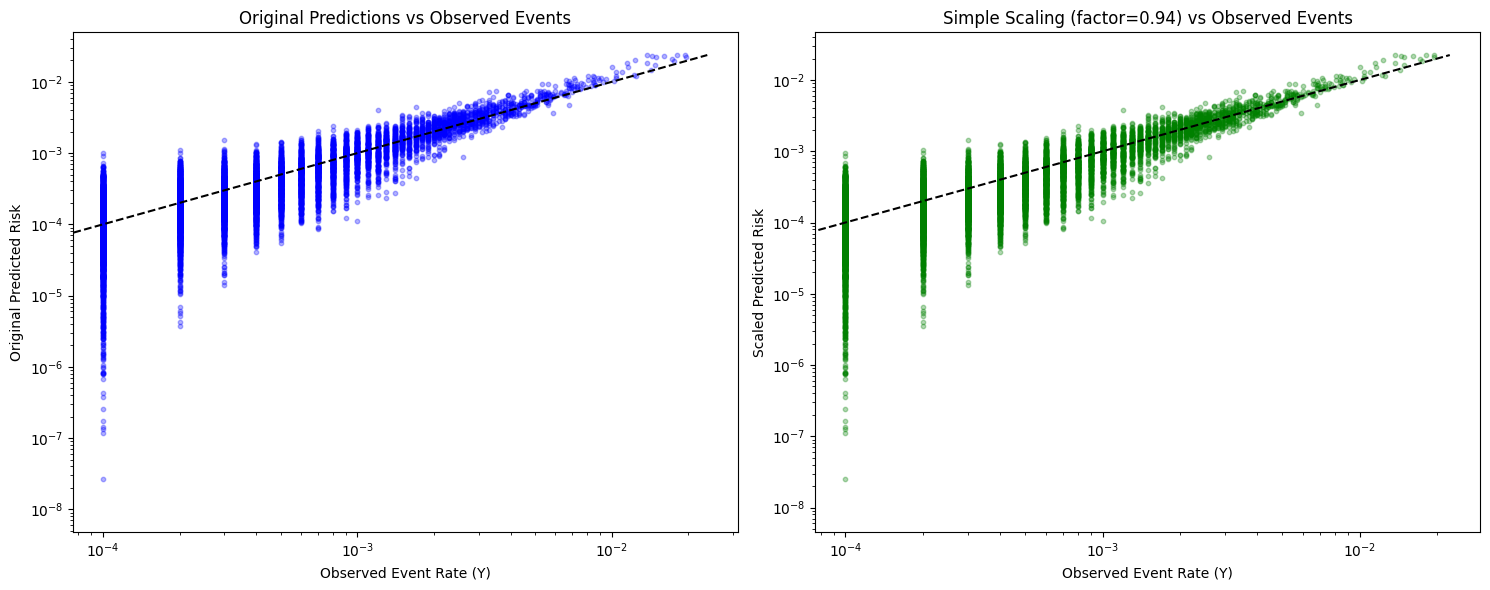

Scale factor: 0.943


In [25]:
# Get predictions
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
predicted_risk_2d = pi_pred.cpu().detach().numpy().mean(axis=0)  # average across individuals

# Get raw observations and calculate scale factor
Y_np = model.Y.cpu().detach().numpy()
Y_mean_2d = Y_np.mean(axis=0)  # average across individuals
scale_factor = Y_mean_2d.mean() / predicted_risk_2d.mean()
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs raw observations
ax1.scatter(Y_mean_2d.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Observed Event Rate (Y)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Observed Events')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs raw observations
ax2.scatter(Y_mean_2d.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Observed Event Rate (Y)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Observed Events')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Scale factor: {scale_factor:.3f}")

In [66]:

ss_res = np.sum((observed_risk - predicted_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.867


In [27]:
def apply_loess_calibration(predicted_risks, observed_risks):
    # Fit LOESS calibration curve
    calibrated_risks = lowess(
        observed_risks, 
        predicted_risks,
        frac=0.3,  # Can tune this parameter
        return_sorted=False
    )
    
    # Apply to predictions
    pi_calibrated = np.zeros_like(pi)
    for d in range(model.D):
        for t in range(model.T):
            risks = pi[:, d, t]
            pi_calibrated[:, d, t] = lowess(
                observed_risks,  # Use same calibration curve
                risks,
                frac=0.3
            )
    
    return pi_calibrated

In [28]:
    calibrated_risks = lowess(
        observed_risk, 
        predicted_risk,
        frac=0.3,  # Can tune this parameter
        return_sorted=False
    )

NameError: name 'lowess' is not defined

In [29]:
def plot_signature_temporal_patterns(model, disease_names, plot_dir, n_top=10, selected_signatures=None):
    """Show temporal patterns of top diseases for each signature"""
    phi = model.phi.detach().numpy()
    prevalence_logit = model.logit_prev_t.detach().numpy()
    import os
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    phi_avg = phi_centered.mean(axis=2)
    
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            disease_name = disease_names[idx]
            ax.plot(temporal_pattern, label=disease_name)
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'temporal_patterns.png'))
    plt.close('all') 

In [30]:
plot_signature_temporal_patterns(model, essentials['disease_names'],'/Users/sarahurbut/Dropbox (Personal)/', n_top=10, selected_signatures=[0,5,6,19])

In [31]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Atrial fibrillation and flutter: effect=1.615 (OR=5.03), std=0.585
Heart failure NOS: effect=1.463 (OR=4.32), std=0.336
Cardiomegaly: effect=1.270 (OR=3.56), std=0.364
Paroxysmal ventricular tachycardia: effect=1.269 (OR=3.56), std=0.113
Aortic valve disease: effect=1.264 (OR=3.54), std=0.142
Pleurisy; pleural effusion: effect=1.254 (OR=3.51), std=0.420
Congestive heart failure (CHF) NOS: effect=1.239 (OR=3.45), std=0.282
Congenital anomalies of great vessels: effect=1.170 (OR=3.22), std=0.198
Mitral valve disease: effect=1.166 (OR=3.21), std=0.287
Pericarditis: effect=1.143 (OR=3.14), std=0.082

Top 10 diseases in Signature 1 (relative to baseline):
Hallux valgus (Bunion): effect=1.277 (OR=3.59), std=0.113
Enthesopathy: effect=1.272 (OR=3.57), std=0.229
Peripheral enthesopathies and allied syndromes: effect=1.259 (OR=3.52), std=0.118
Other disorders of synovium, tendon, and bursa: effect=1.223 (OR=3.40), std=0.076
Pain in joint: 

In [32]:
mean_phi=model.phi.detach().cpu().numpy()

In [33]:
initial_psi[:,112]

tensor([-1.9906, -2.0008, -2.0034, -2.0126, -1.9857,  0.8679, -1.9930, -2.0030,
        -2.0053, -2.0097, -1.9918, -1.9775, -2.0165, -1.9968, -1.9910, -2.0046,
        -1.9988, -1.9991, -1.9921, -1.9857, -5.0022])

In [34]:
model.psi[:,112]

tensor([-2.4133, -2.0282, -2.0700, -2.1973, -1.9229, -1.2272, -2.1277, -2.0557,
        -2.0092, -2.2590, -2.1735, -2.0738, -2.0585, -2.0330, -1.8766, -1.9685,
        -2.5690, -2.4836, -2.0029, -2.0967, -4.9747],
       grad_fn=<SelectBackward0>)

In [37]:
model.K=21

In [65]:
model.kappa

Parameter containing:
tensor([2.9875], requires_grad=True)

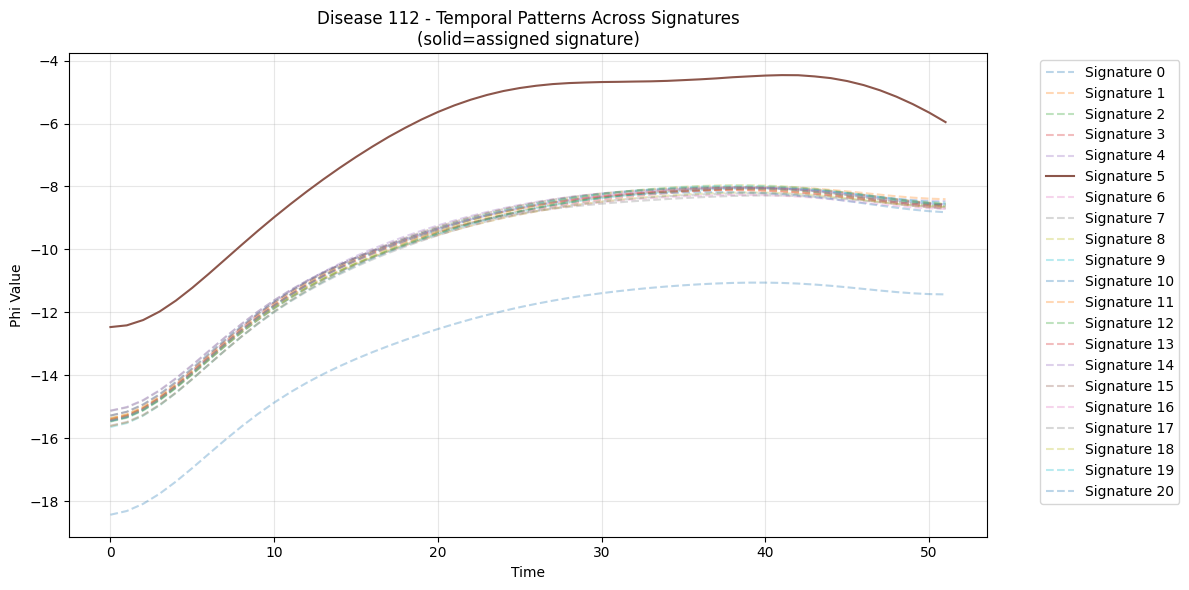


Psi values for disease 112:
Signature 0: -2.413
Signature 1: -2.028
Signature 2: -2.070
Signature 3: -2.197
Signature 4: -1.923
Signature 5: -1.227
Signature 6: -2.128
Signature 7: -2.056
Signature 8: -2.009
Signature 9: -2.259
Signature 10: -2.174
Signature 11: -2.074
Signature 12: -2.059
Signature 13: -2.033
Signature 14: -1.877
Signature 15: -1.968
Signature 16: -2.569
Signature 17: -2.484
Signature 18: -2.003
Signature 19: -2.097
Signature 20: -4.975


In [38]:
def plot_disease_signature_patterns(model, disease_idx=112):
    plt.figure(figsize=(12, 6))
    time_points = np.arange(model.T)
    
    # Get phi values for this disease across all signatures
    phi_disease = model.phi[:, disease_idx].detach()  # [K, T]
    psi_disease = model.psi[:, disease_idx].detach()  # [K]
    
    # Plot phi trajectories
    for k in range(model.K):
        # Make the assigned signature (highest psi) stand out
        is_assigned = (psi_disease[k] == psi_disease.max())
        alpha = 1.0 if is_assigned else 0.3
        linestyle = '-' if is_assigned else '--'
        
        plt.plot(time_points, phi_disease[k], 
                label=f'Signature {k}', 
                alpha=alpha,
                linestyle=linestyle)
    
    plt.title(f'Disease {disease_idx} - Temporal Patterns Across Signatures\n(solid=assigned signature)')
    plt.xlabel('Time')
    plt.ylabel('Phi Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print psi values
    print(f"\nPsi values for disease {disease_idx}:")
    for k in range(model.K):
        print(f"Signature {k}: {psi_disease[k]:.3f}")

# Call the function for MI (disease 112)
plot_disease_signature_patterns(model, disease_idx=112)

In [39]:
# Get gradients for each parameter
psi_grad = model.psi.grad
phi_grad = model.phi.grad
lambda_grad = model.lambda_.grad
gamma_grad = model.gamma.grad
#lrtpen_grad = model.lrtpen.grad if model.lrtpen.grad is not None else None
#gpweight_grad = model.gpweight.grad if model.gpweight.grad is not None else None

# Print gradient statistics
print("PSI gradients:")
print(f"Mean: {psi_grad.abs().mean():.3e}")
print(f"Max: {psi_grad.abs().max():.3e}")

print("\nPHI gradients:")
print(f"Mean: {phi_grad.abs().mean():.3e}")
print(f"Max: {phi_grad.abs().max():.3e}")

print("\nLAMBDA gradients:")
print(f"Mean: {lambda_grad.abs().mean():.3e}")
print(f"Max: {lambda_grad.abs().max():.3e}")

print("\nGAMMA gradients:")
print(f"Mean: {gamma_grad.abs().mean():.3e}")
print(f"Max: {gamma_grad.abs().max():.3e}")

#if lrtpen_grad is not None:
    #print("\nLRT penalty gradient:", lrtpen_grad.item())
    
#if gpweight_grad is not None:
    #print("\nGP weight gradient:", gpweight_grad.item())

PSI gradients:
Mean: 1.822e-08
Max: 2.745e-06

PHI gradients:
Mean: 6.226e-06
Max: 1.130e-03

LAMBDA gradients:
Mean: 1.375e-06
Max: 3.308e-04

GAMMA gradients:
Mean: 1.081e-07
Max: 1.827e-06


In [40]:
model.psi

Parameter containing:
tensor([[-1.8417, -1.7897, -2.0656,  ..., -2.0732, -2.0569, -2.1246],
        [-1.9353, -1.9498, -1.9801,  ..., -2.1510, -2.1403, -2.1236],
        [-1.8793, -1.9473, -2.0967,  ..., -2.0577, -2.0921, -1.9607],
        ...,
        [-1.9688, -2.0017, -1.8849,  ..., -2.0066, -2.0245, -1.9279],
        [-2.0569, -1.9420, -2.0179,  ..., -1.9600, -2.0439, -2.1095],
        [-4.9892, -4.9906, -5.0867,  ..., -5.0224, -4.9882, -4.9185]],
       requires_grad=True)

In [41]:
initial_psi

tensor([[-2.0162, -1.9909, -1.9982,  ..., -1.9936, -1.9885, -2.0048],
        [-2.0034, -1.9774, -2.0040,  ..., -1.9989, -2.0033, -1.9827],
        [-1.9909, -1.9892, -2.0000,  ..., -1.9940, -1.9808, -2.0092],
        ...,
        [-2.0022, -1.9927, -1.9903,  ..., -1.9766, -2.0031, -2.0167],
        [-1.9907, -1.9997, -1.9918,  ..., -1.9948, -1.9953, -1.9874],
        [-5.0113, -5.0115, -5.0025,  ..., -4.9993, -4.9923, -5.0097]])

In [42]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Paroxysmal ventricular tachycardia: 1.079
2. Pericarditis: 1.029
3. Heart failure NOS: 0.780
4. Mitral valve disease: 0.777
5. Cardiomegaly: 0.751
6. Congestive heart failure (CHF) NOS: 0.453
7. Aortic valve disease: 0.213
8. Paroxysmal supraventricular tachycardia: 0.143
9. Primary/intrinsic cardiomyopathies: -0.138
10. Congenital anomalies of great vessels: -0.314

Final top diseases:
1. Atrial fibrillation and flutter: 1.615
2. Heart failure NOS: 1.463
3. Cardiomegaly: 1.270
4. Paroxysmal ventricular tachycardia: 1.269
5. Aortic valve disease: 1.264
6. Pleurisy; pleural effusion: 1.254
7. Congestive heart failure (CHF) NOS: 1.239
8. Congenital anomalies of great vessels: 1.170
9. Mitral valve disease: 1.166
10. Pericarditis: 1.143

Pleurisy; pleural effusion changed from rank 12 to 6

Mitral valve disease changed from rank 4 to 9

Pericarditis changed from rank 2 to 10

Primary/intrinsic cardiomyopathies changed from rank 9 to 12

Paroxysmal s

In [160]:
model.K=21

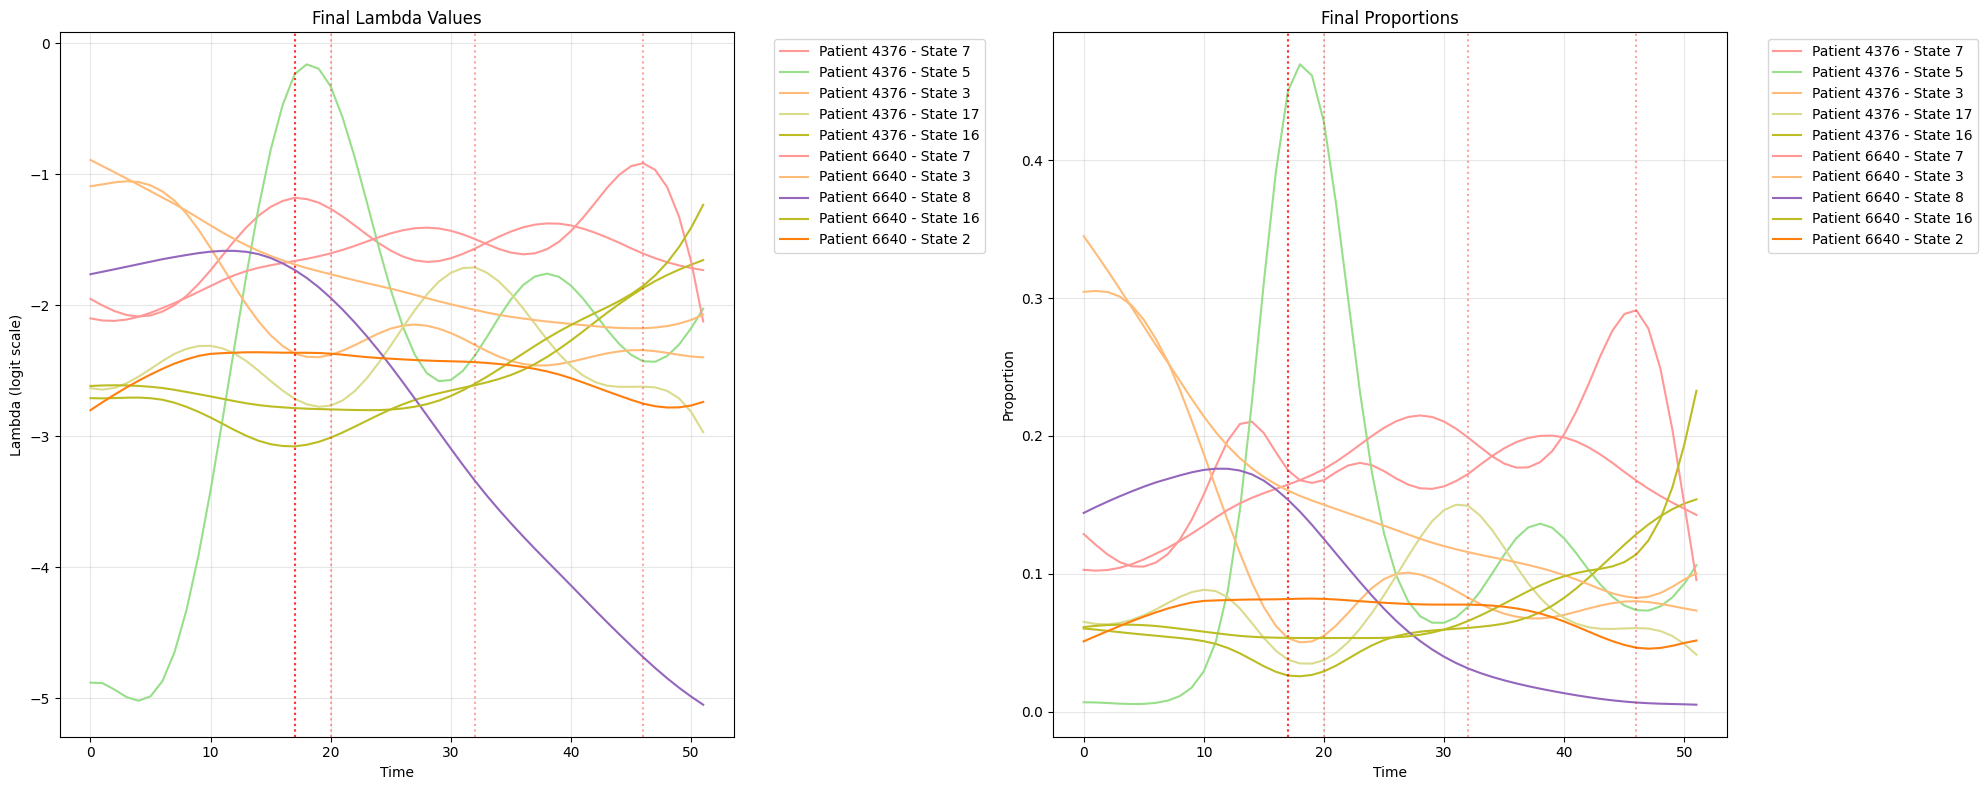


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.057
Std of shifts: 0.154
Range of shifts: [-0.178, 0.444]

Top states and average proportions:
State 7: 0.166
State 5: 0.131
State 3: 0.121
State 17: 0.078
State 16: 0.068

Patient 6640:
Mean shift: 0.037
Std of shifts: 0.087
Range of shifts: [-0.146, 0.192]

Top states and average proportions:
State 7: 0.179
State 3: 0.158
State 8: 0.085
State 16: 0.078
State 2: 0.070


In [43]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times for this patient
    diagnoses = model.Y[patient]  # Shape: [D, T]
    diagnosis_times = []
    for d in range(model.D):
        diag_time = torch.where(diagnoses[d])[0]
        if len(diag_time) > 0:
            diagnosis_times.append(diag_time[0].item())
            
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')
    
    # Add vertical lines for diagnoses
    for t in diagnosis_times:
        ax1.axvline(x=t, color='red', alpha=0.2, linestyle=':')
        ax2.axvline(x=t, color='red', alpha=0.2, linestyle=':')

# Customize plots
ax1.set_title('Final Lambda Values')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects and top states
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

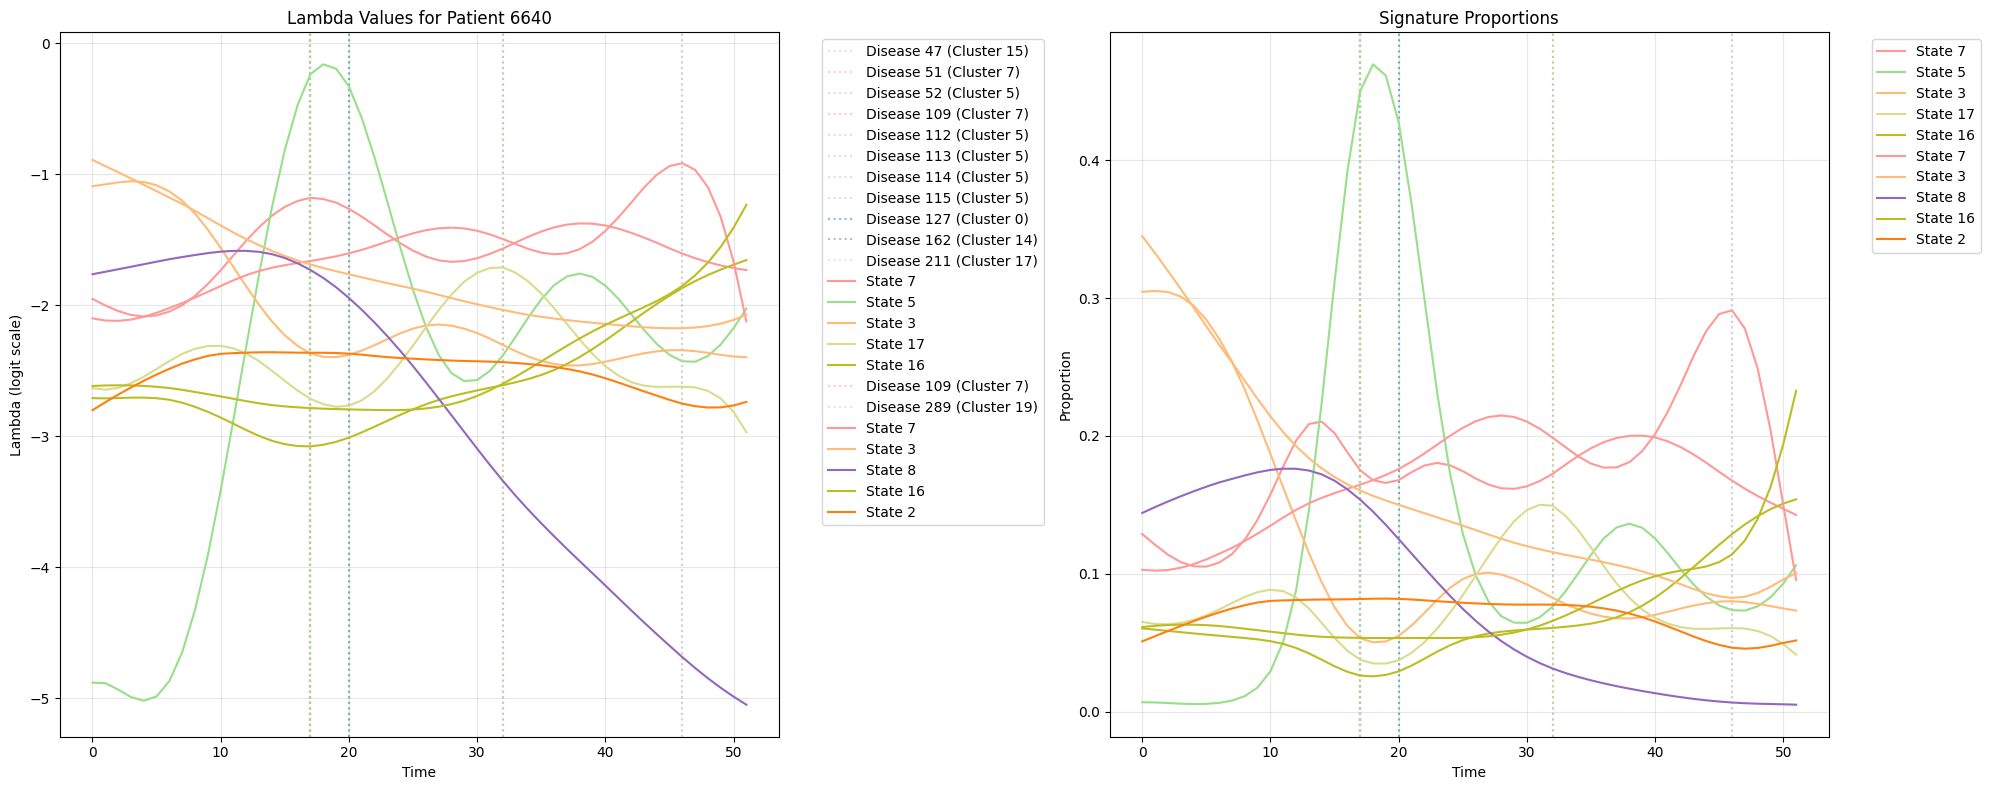

In [67]:
n_samples = 2
sample_patients = [4376, 6640]
n_top_states = 5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]
patient_props = torch.softmax(lambda_patients, dim=1)
mean_props = patient_props.mean(dim=-1)
top_states = mean_props.topk(n_top_states, dim=-1).indices

# Color map for states
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times and associated clusters
    diagnoses = model.Y[patient]  # Shape: [D, T]
    for d in range(model.D):
        diag_times = torch.where(diagnoses[d])[0]
        if len(diag_times) > 0:
            diag_time = diag_times[0].item()
            # Get cluster assignment for this disease
            cluster = model.clusters[d]
            # Use cluster's color for the vertical line
            ax1.axvline(x=diag_time, color=colors[cluster], alpha=0.5, linestyle=':', 
                       label=f'Disease {d} (Cluster {cluster})')
            ax2.axvline(x=diag_time, color=colors[cluster], alpha=0.5, linestyle=':')
            
    # Plot lambda trajectories
    for j, k in enumerate(top_states[i]):
        k = k.item()
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'State {k}')

# Customize plots
ax1.set_title(f'Lambda Values for Patient {patient}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Signature Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [73]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Dropbox (Personal)/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [69]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=label)

In [70]:
Y.shape

(10000, 348, 52)

In [71]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using LOESS calibrated risks
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using calibrated predictions
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        ascvd_timeprob = 1 - np.prod(1 - pi_ascvd, axis=0)
        risk = 1 - np.prod(1 - ascvd_timeprob)
        our_10yr_risks.append(risk)
        
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['pce_goff'].values[:len(our_10yr_risks)]

    # Get indices of non-missing PCE values
    non_missing_idx = ~np.isnan(pce_risks)

    # Filter all arrays to only include non-missing cases
    our_10yr_risks_filtered = our_10yr_risks[non_missing_idx]
    actual_10yr_filtered = actual_10yr[non_missing_idx]
    pce_risks_filtered = pce_risks[non_missing_idx]

    # Calculate ROC AUCs on filtered data
    our_auc = roc_auc_score(actual_10yr_filtered, our_10yr_risks_filtered)
    pce_auc = roc_auc_score(actual_10yr_filtered, pce_risks_filtered)

    # Print results with sample size info
    n_total = len(our_10yr_risks)
    n_complete = len(our_10yr_risks_filtered)
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Sample size: {n_complete}/{n_total} ({n_complete/n_total*100:.1f}% complete cases)")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")

    # Plot ROC curves
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr_filtered, our_10yr_risks_filtered, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr_filtered, pce_risks_filtered, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    return our_10yr_risks_filtered, actual_10yr_filtered, pce_risks_filtered


ROC AUC Comparison (10-year prediction from enrollment):
Sample size: 7817/10000 (78.2% complete cases)
Our model: 0.869
PCE: 0.711


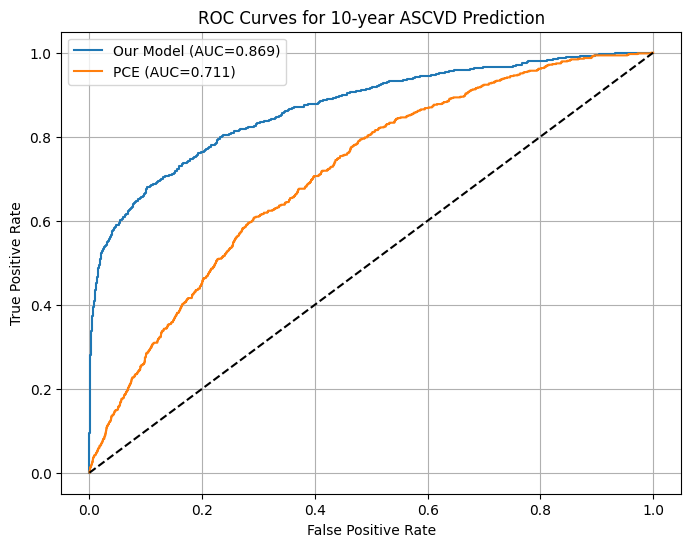

(array([0.1206219 , 0.02830549, 0.11228634, ..., 0.21617175, 0.09587901,
        0.04664273]),
 array([False, False, False, ...,  True, False, False]),
 array([0.20861924, 0.12870708, 0.12895867, ..., 0.13201657, 0.11094535,
        0.0075447 ]))

In [72]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])


ROC AUC Comparison (10-year prediction from enrollment):
Our model: 0.865
PCE: 0.678


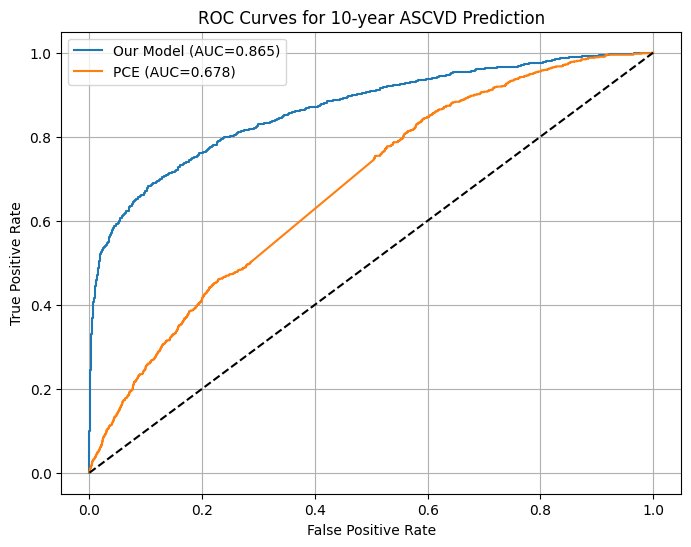

In [50]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

# Now plot using just the time point (ie not accumulated)


ROC AUC Comparison (10-year prediction from enrollment):
Our model: 0.791
PCE: 0.678


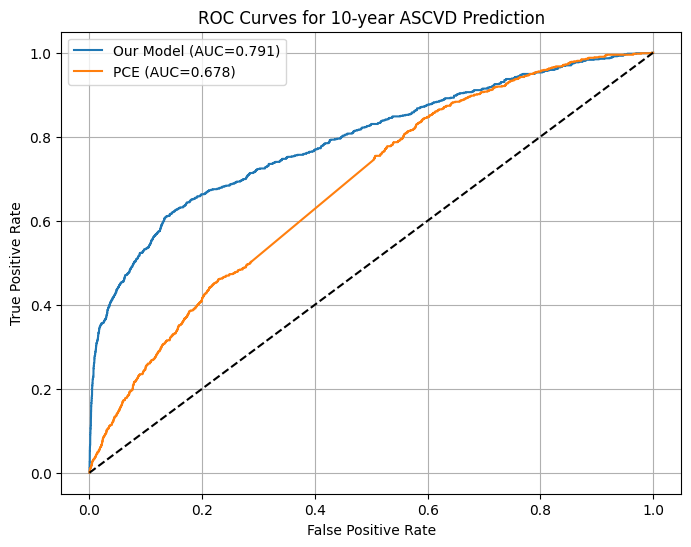

In [54]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    # Rest of the function remains the same
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['pce_goff_fuull'].values[:len(our_10yr_risks)]
    
    # Calculate ROC AUCs
    our_auc = roc_auc_score(actual_10yr, our_10yr_risks)
    pce_auc = roc_auc_score(actual_10yr, pce_risks)
    
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, our_10yr_risks, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

In [78]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction, handling missing PCE values
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['pce_goff'].values[:len(our_10yr_risks)]

    # Get indices of non-missing PCE values
    non_missing_idx = ~np.isnan(pce_risks)

    # Filter all arrays to only include non-missing cases
    our_10yr_risks_filtered = our_10yr_risks[non_missing_idx]
    actual_10yr_filtered = actual_10yr[non_missing_idx]
    pce_risks_filtered = pce_risks[non_missing_idx]

    # Calculate ROC AUCs on filtered data
    our_auc = roc_auc_score(actual_10yr_filtered, our_10yr_risks_filtered)
    pce_auc = roc_auc_score(actual_10yr_filtered, pce_risks_filtered)

    # Print results with sample size info
    n_total = len(our_10yr_risks)
    n_complete = len(our_10yr_risks_filtered)
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Sample size: {n_complete}/{n_total} ({n_complete/n_total*100:.1f}% complete cases)")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr_filtered, our_10yr_risks_filtered, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr_filtered, pce_risks_filtered, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    return our_10yr_risks_filtered, actual_10yr_filtered, pce_risks_filtered


ROC AUC Comparison (10-year prediction from enrollment):
Sample size: 7817/10000 (78.2% complete cases)
Our model: 0.797
PCE: 0.711


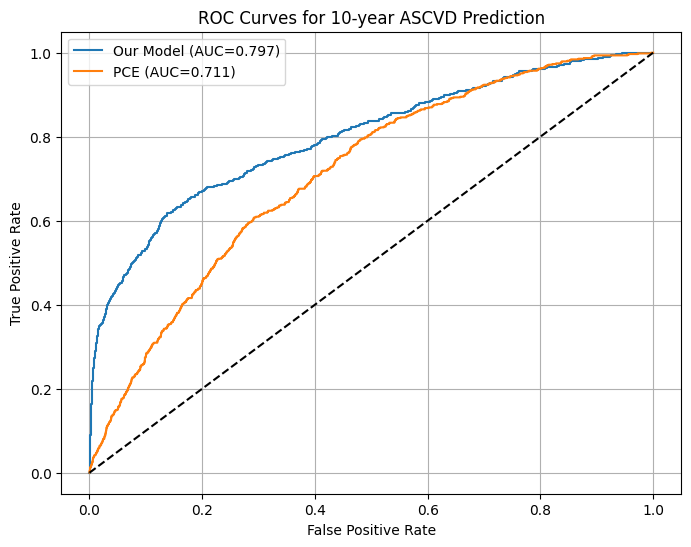

(array([0.15994827, 0.00680454, 0.13584605, ..., 0.21100293, 0.07434523,
        0.0182545 ]),
 array([False, False, False, ...,  True, False, False]),
 array([0.20861924, 0.12870708, 0.12895867, ..., 0.13201657, 0.11094535,
        0.0075447 ]))

In [79]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

In [82]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction, handling missing PCE values
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['prevent_base_ascvd_risk'].values[:len(our_10yr_risks)]

    # Get indices of non-missing PCE values
    non_missing_idx = ~np.isnan(pce_risks)

    # Filter all arrays to only include non-missing cases
    our_10yr_risks_filtered = our_10yr_risks[non_missing_idx]
    actual_10yr_filtered = actual_10yr[non_missing_idx]
    pce_risks_filtered = pce_risks[non_missing_idx]

    # Calculate ROC AUCs on filtered data
    our_auc = roc_auc_score(actual_10yr_filtered, our_10yr_risks_filtered)
    pce_auc = roc_auc_score(actual_10yr_filtered, pce_risks_filtered)

    # Print results with sample size info
    n_total = len(our_10yr_risks)
    n_complete = len(our_10yr_risks_filtered)
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Sample size: {n_complete}/{n_total} ({n_complete/n_total*100:.1f}% complete cases)")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr_filtered, our_10yr_risks_filtered, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr_filtered, pce_risks_filtered, label=f'Prevent (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    return our_10yr_risks_filtered, actual_10yr_filtered, pce_risks_filtered


ROC AUC Comparison (10-year prediction from enrollment):
Sample size: 7172/10000 (71.7% complete cases)
Our model: 0.800
PCE: 0.698


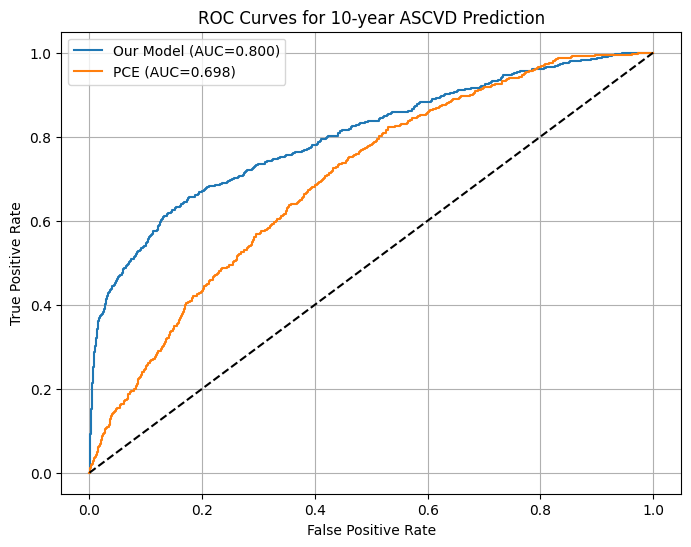

(array([0.15994827, 0.00680454, 0.13584605, ..., 0.21100293, 0.07434523,
        0.0182545 ]),
 array([False, False, False, ...,  True, False, False]),
 array([0.0888042 , 0.03141781, 0.07353702, ..., 0.06911332, 0.05043977,
        0.00757175]))

In [81]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

In [76]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions using single timepoint prediction
    """
    our_10yr_risks = []
    actual_10yr = []

    # Get predictions
    pi = model.forward()[0].detach().numpy()
    
    # Get mean risks across patients for calibration
    predicted_risk_2d = pi.mean(axis=0)  # Shape: [D, T]
    observed_risk_2d = model.Y.numpy().mean(axis=0)  # Shape: [D, T]
    
    # Sort and get LOESS calibration curve
    pred_flat = predicted_risk_2d.flatten()
    obs_flat = observed_risk_2d.flatten()
    sort_idx = np.argsort(pred_flat)
    smoothed = lowess(obs_flat[sort_idx], pred_flat[sort_idx], frac=0.3)
    
    # Apply calibration to all predictions using interpolation
    pi_calibrated = np.interp(pi.flatten(), smoothed[:, 0], smoothed[:, 1]).reshape(pi.shape)
    
    # Calculate 10-year risks using only enrollment time prediction
    for patient_idx, row in enumerate(pce_df.itertuples()):
        enroll_time = int(row.age - 30)
        if enroll_time + 10 >= model.T:
            continue
            
        # Only use predictions at enrollment time
        pi_ascvd = pi_calibrated[patient_idx, ascvd_indices, enroll_time]
        
        # Calculate 1-year risk first
        yearly_risk = 1 - np.prod(1 - pi_ascvd)
        
        # Convert to 10-year risk
        risk = 1 - (1 - yearly_risk)**10
        our_10yr_risks.append(risk)
        
        # Still look at actual events over 10 years
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
   
    # Rest of the function remains the same
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['prevent_impute'].values[:len(our_10yr_risks)]
    
    # Calculate ROC AUCs
    our_auc = roc_auc_score(actual_10yr, our_10yr_risks)
    pce_auc = roc_auc_score(actual_10yr, pce_risks)
    
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, our_10yr_risks, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks, label=f'PREVENT (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()



ROC AUC Comparison (10-year prediction from enrollment):
Our model: 0.791
PCE: 0.653


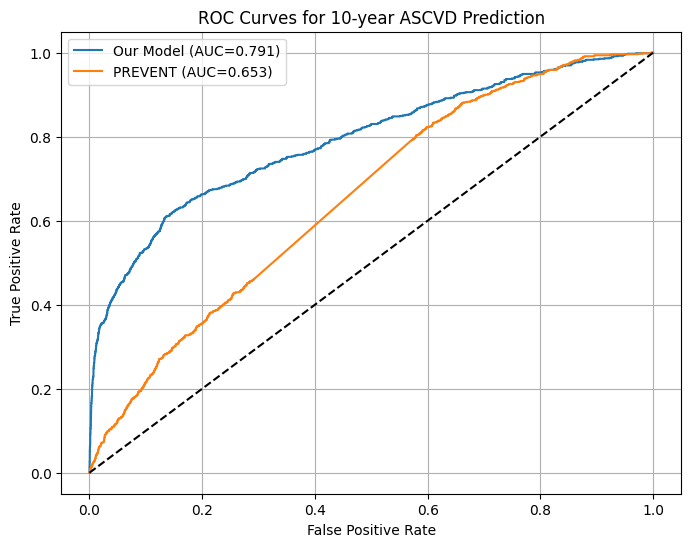

In [77]:
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

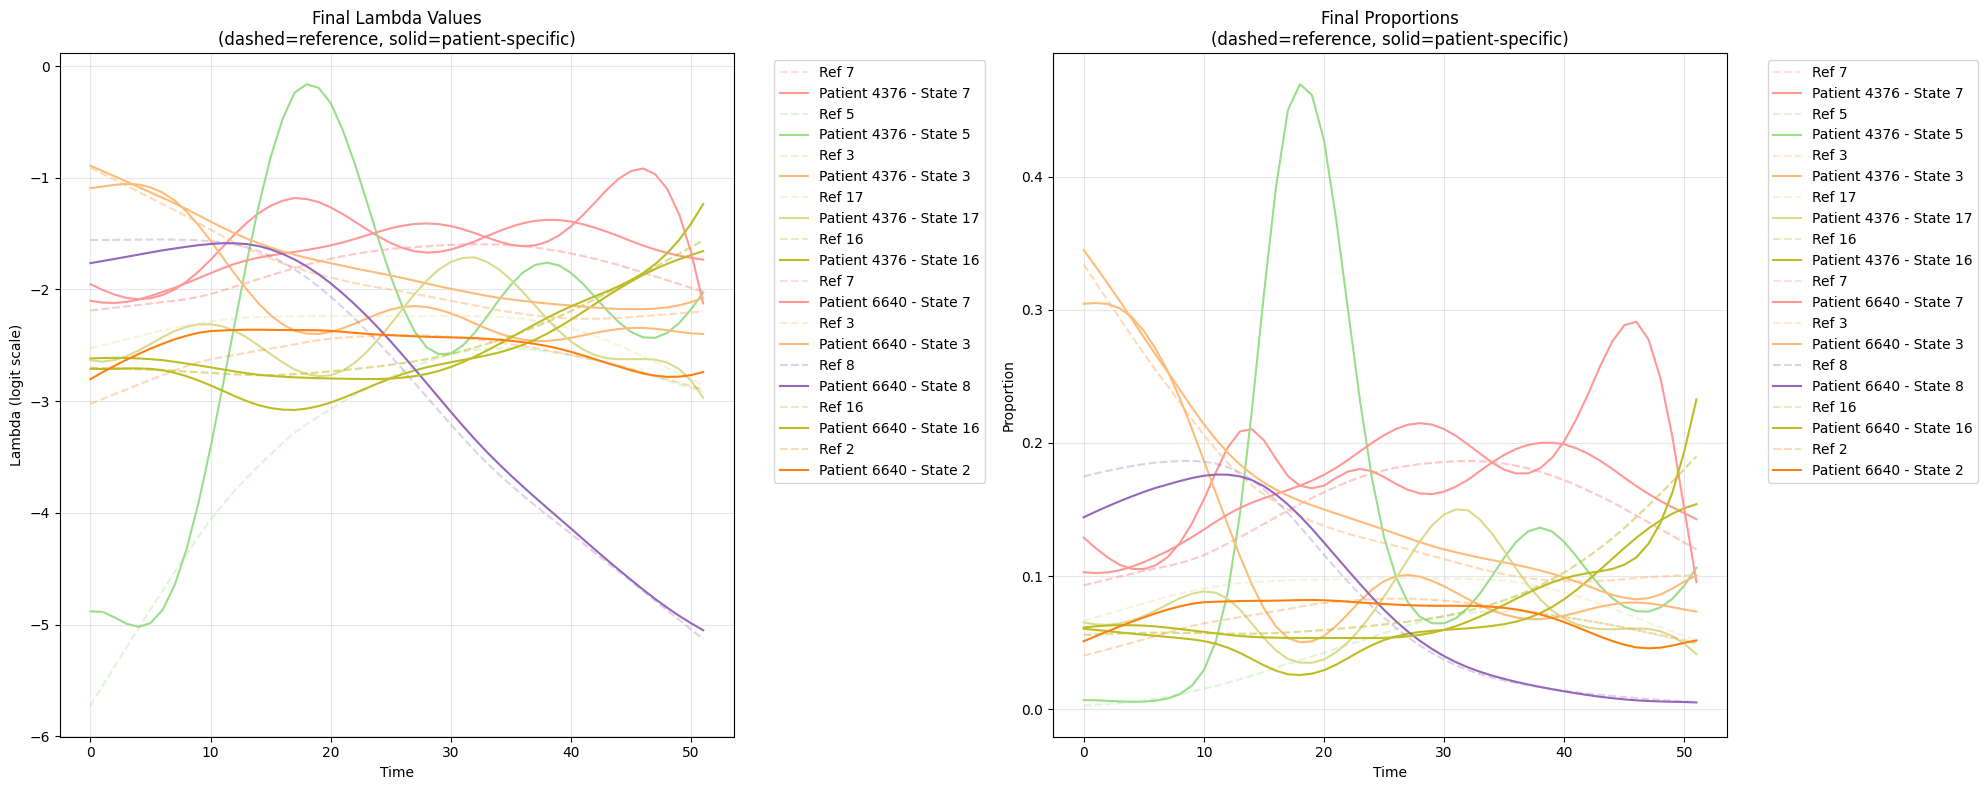


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.057
Std of shifts: 0.154
Range of shifts: [-0.178, 0.444]

Top states and average proportions:
State 7: 0.166
State 5: 0.131
State 3: 0.121
State 17: 0.078
State 16: 0.068

Patient 6640:
Mean shift: 0.037
Std of shifts: 0.087
Range of shifts: [-0.146, 0.192]

Top states and average proportions:
State 7: 0.179
State 3: 0.158
State 8: 0.085
State 16: 0.078
State 2: 0.070


In [55]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients].detach()  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Final Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [52]:
predicted_risk.shape

(18096,)

0.94256353


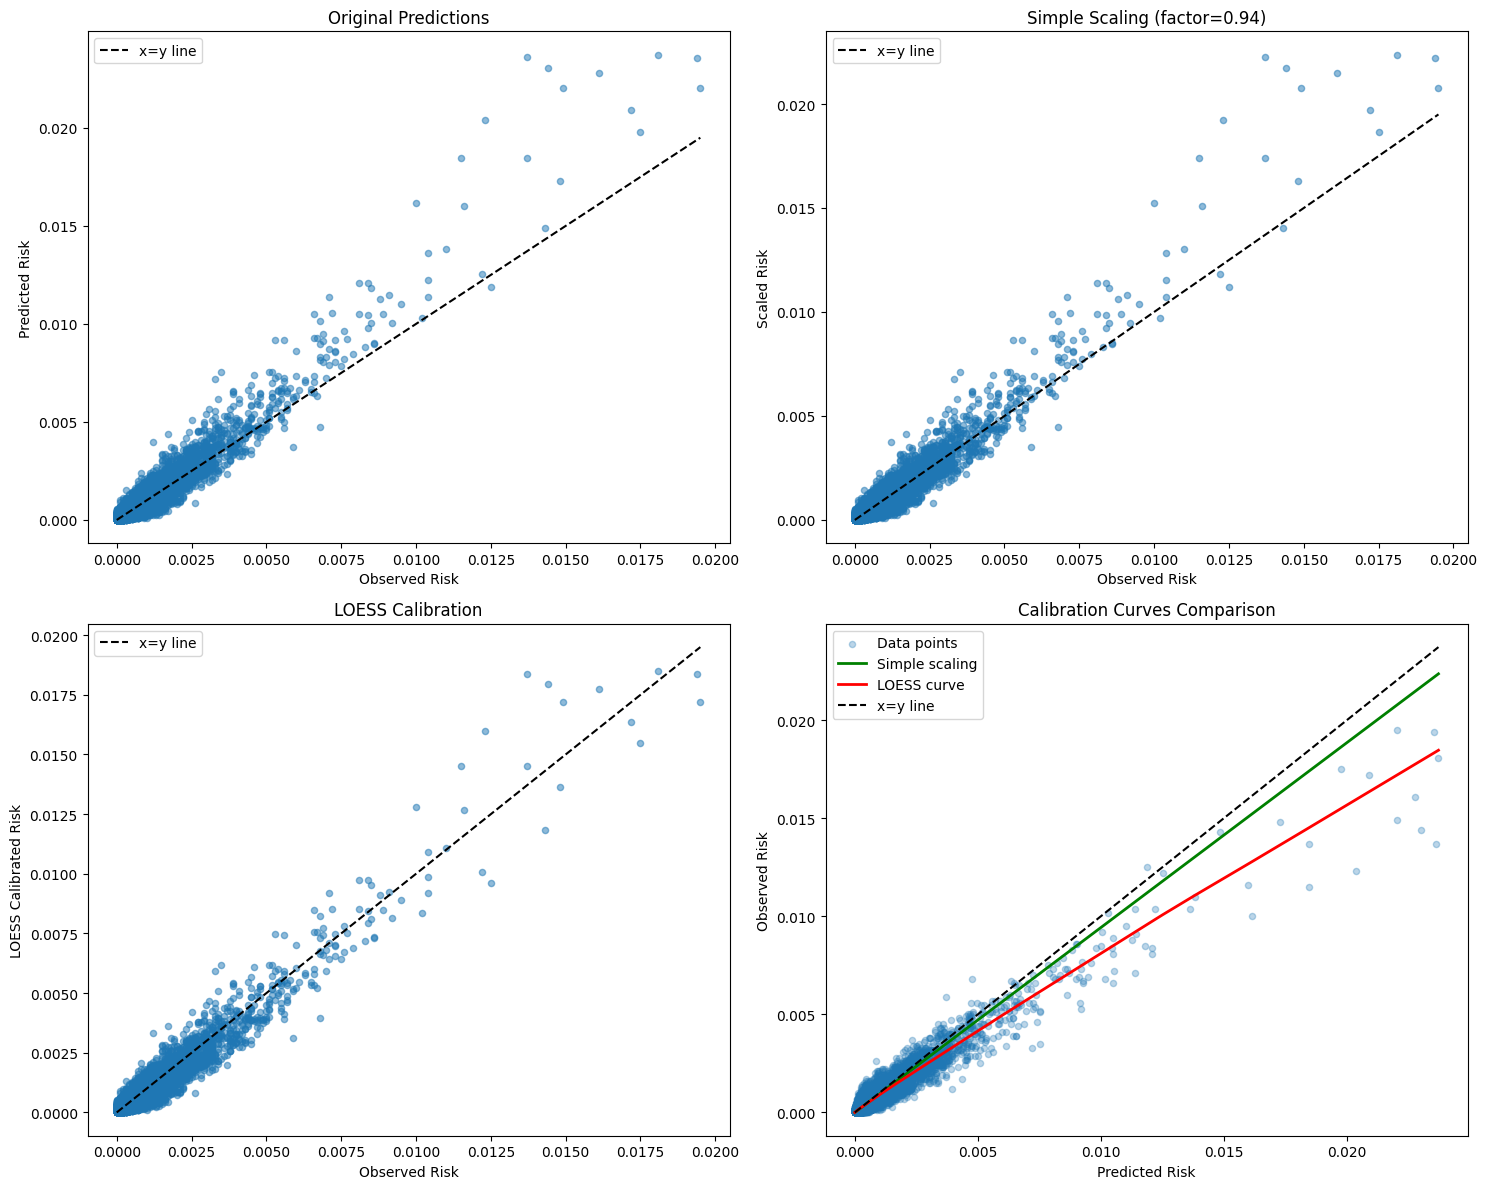


Performance Metrics:
Original R²: 0.867
Simple Scaling R²: 0.896
LOESS Calibrated R²: 0.927

Original RMSE: 0.000337
Simple Scaling RMSE: 0.000298
LOESS Calibrated RMSE: 0.000249


In [58]:

# Calculate both calibration methods
# Simple scaling
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
print(scale_factor)
scaled_risk = predicted_risk * scale_factor

# LOESS calibration
loess_risk = lowess(observed_risk, predicted_risk, frac=0.3, return_sorted=False)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original predictions
ax1.scatter(observed_risk, predicted_risk, alpha=0.5, s=20)
ax1.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax1.set_title('Original Predictions')
ax1.set_xlabel('Observed Risk')
ax1.set_ylabel('Predicted Risk')
ax1.legend()

# Simple scaling calibration
ax2.scatter(observed_risk, scaled_risk, alpha=0.5, s=20)
ax2.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f})')
ax2.set_xlabel('Observed Risk')
ax2.set_ylabel('Scaled Risk')
ax2.legend()

# LOESS calibration
ax3.scatter(observed_risk, loess_risk, alpha=0.5, s=20)
ax3.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax3.set_title('LOESS Calibration')
ax3.set_xlabel('Observed Risk')
ax3.set_ylabel('LOESS Calibrated Risk')
ax3.legend()

# Calibration curves comparison
sort_idx = np.argsort(predicted_risk)
pred_sorted = predicted_risk[sort_idx]
obs_sorted = observed_risk[sort_idx]
smoothed = lowess(obs_sorted, pred_sorted, frac=0.3)

ax4.scatter(predicted_risk, observed_risk, alpha=0.3, s=20, label='Data points')
ax4.plot(pred_sorted, pred_sorted * scale_factor, 'g-', label='Simple scaling', linewidth=2)
ax4.plot(smoothed[:, 0], smoothed[:, 1], 'r-', label='LOESS curve', linewidth=2)
ax4.plot([0, max(predicted_risk)], [0, max(predicted_risk)], 'k--', label='x=y line')
ax4.set_title('Calibration Curves Comparison')
ax4.set_xlabel('Predicted Risk')
ax4.set_ylabel('Observed Risk')
ax4.legend()

plt.tight_layout()
plt.show()

# Print performance metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nPerformance Metrics:")
print(f"Original R²: {r2_score(observed_risk, predicted_risk):.3f}")
print(f"Simple Scaling R²: {r2_score(observed_risk, scaled_risk):.3f}")
print(f"LOESS Calibrated R²: {r2_score(observed_risk, loess_risk):.3f}")
print(f"\nOriginal RMSE: {np.sqrt(mean_squared_error(observed_risk, predicted_risk)):.6f}")
print(f"Simple Scaling RMSE: {np.sqrt(mean_squared_error(observed_risk, scaled_risk)):.6f}")
print(f"LOESS Calibrated RMSE: {np.sqrt(mean_squared_error(observed_risk, loess_risk)):.6f}")

In [57]:
essentials['prevalence_t']

array([[1.69567120e-05, 1.75893347e-05, 1.88782979e-05, ...,
        1.08835455e-04, 1.04374347e-04, 1.02135520e-04],
       [2.68736881e-06, 2.85423562e-06, 3.20238269e-06, ...,
        1.18538810e-04, 1.14539289e-04, 1.12490707e-04],
       [2.97181600e-07, 3.30504719e-07, 4.04821947e-07, ...,
        3.29991919e-04, 3.24798864e-04, 3.22023610e-04],
       ...,
       [1.33744152e-05, 1.37726638e-05, 1.45833792e-05, ...,
        5.58665721e-04, 5.51545003e-04, 5.47744974e-04],
       [1.67175514e-07, 1.90169047e-07, 2.43914428e-07, ...,
        1.23406190e-03, 1.21272355e-03, 1.20137166e-03],
       [1.02264755e-06, 1.13695830e-06, 1.39220663e-06, ...,
        1.37426832e-04, 1.29557186e-04, 1.25660023e-04]])

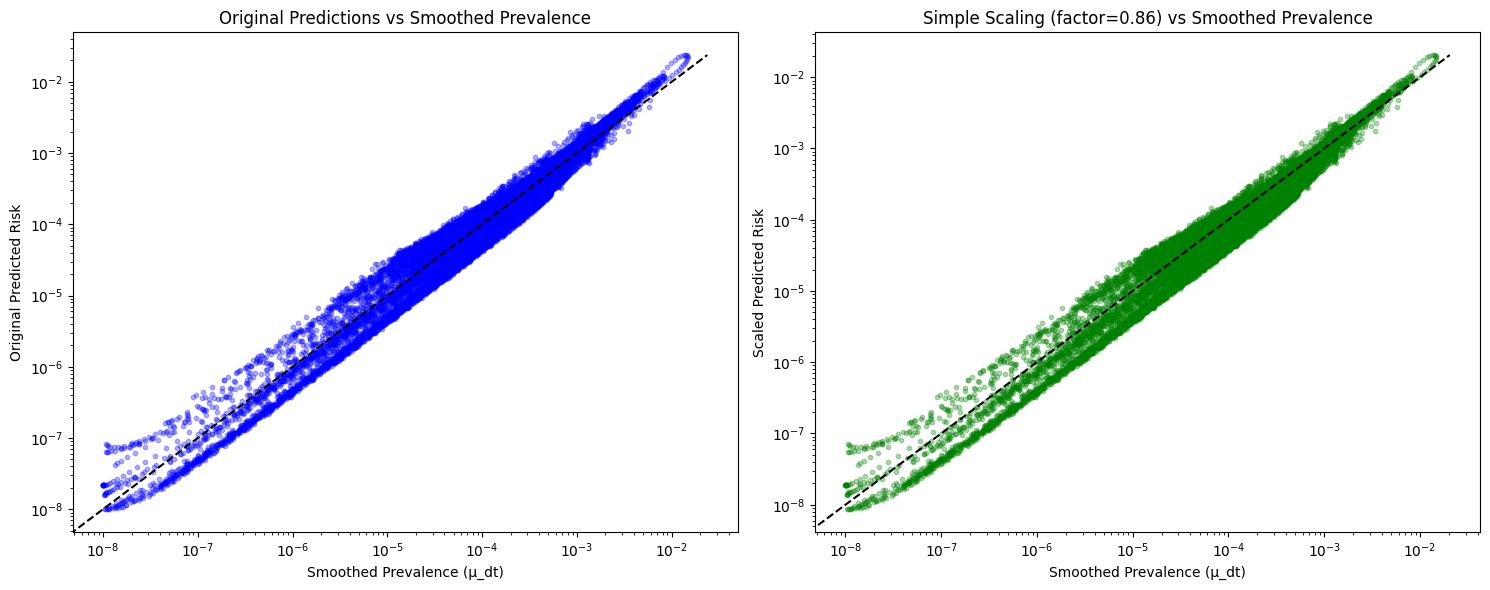

In [56]:
# Get μ_dt from checkpoint and predictions

mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()